In [0]:
!pip3 uninstall pytorch-hrvvi-ext -y
!pip3 install -U git+https://github.com/sbl1996/pytorch-hrvvi-ext.git


In [1]:
import sys
import os

import torch
import hutil
import matplotlib.pyplot as plt
print(hutil.__version__)

1.4.14


In [0]:
%load_ext autoreload
%autoreload 2

In [3]:
gdrive = "/gdrive"
from google.colab import drive
drive.mount(gdrive, force_remount=True)
mydrive = os.path.join(gdrive, "My Drive")
!ls /gdrive/My\ Drive

def gpath(p):
    return os.path.join(mydrive, p)

Mounted at /gdrive
'Colab Notebooks'   eng-fra.pt	 images   repo	   weixin.pkl
 datasets	    fonts	 models   result


In [4]:
import math
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam, SGD
from torch.optim.lr_scheduler import LambdaLR, MultiStepLR
from torch.utils.data import DataLoader

from hutil import cuda, one_hot
from hutil.train import init_weights, Trainer
from hutil.data import train_test_split, Fullset
from hutil.transforms.detection import Compose, Resize, CenterCrop, ToTensor, ToPercentCoords
from hutil.ext.captcha import ImageCaptcha
from hutil.datasets import CaptchaDetectionOnline
from hutil.train.metrics import TrainLoss, MeanAveragePrecision
from hutil.detection import BBox, box_collate_fn, transform_bboxes, transform_bbox, iou_1m, non_max_suppression
from hutil.ext.summary import summary
from hutil.inference import freeze


In [0]:

def compute_default_boxes(lx, ly, priors):
    default_boxes = torch.zeros(lx, ly, len(priors), 4)
    default_boxes[:, :, :, 0] = (torch.arange(
        lx, dtype=torch.float).view(lx, 1, 1).expand(lx, ly, len(priors)) + 0.5) / lx
    default_boxes[:, :, :, 1] = (torch.arange(
        ly, dtype=torch.float).view(1, ly, 1).expand(lx, ly, len(priors)) + 0.5) / ly
    default_boxes[:, :, :, 2:] = priors / torch.FloatTensor([lx, ly])
    return default_boxes


def inverse_sigmoid(x):
    x = min(max(x, .01), .99)
    return math.log(x / (1 - x))


def scale_boxes(boxes, width, height, inplace=False):
    r"""
    Args:
        boxes: (batch_size, lx, ly, num_priors, 4)
    """
    if not inplace:
        boxes = boxes.clone()
    lx, ly = boxes.shape[1:3]
    sw = width / lx
    sh = height / ly
    offset_x = torch.arange(
        lx, dtype=boxes.dtype, device=boxes.device).view(1, -1, 1, 1)
    boxes[..., 0] += offset_x
    boxes[..., [0, 2]] *= sw

    offset_y = torch.arange(
        ly, dtype=boxes.dtype, device=boxes.device).view(1, 1, -1, 1)
    boxes[..., 1] += offset_y
    boxes[..., [1, 3]] *= sh
    return boxes


In [0]:

class YOLOTransform:

    def __init__(self, default_boxes, priors, num_classes, ignore_threshold=0.7, label_field="category_id", bbox_field="bbox"):
        self.default_boxes = default_boxes
        self.num_classes = num_classes
        self.ignore_threshold = ignore_threshold
        self.label_field = label_field
        self.bbox_field = bbox_field

    def __call__(self, img, anns):
        num_feature_maps = len(self.default_boxes)
        shapes = []
        default_boxes = []
        loc_target = []
        cls_target = []
        iou_masks = []
        for i in range(num_feature_maps):
            shapes.append(self.default_boxes[i].shape[:3])
            d_boxes = self.default_boxes[i].view(-1, 4)
            default_boxes.append(d_boxes)
            num_anchors = d_boxes.size(0)
            loc_target.append(torch.zeros(
                num_anchors, 4))
            cls_target.append(torch.full(
                (num_anchors,), self.num_classes, dtype=torch.long))
            iou_masks.append(torch.zeros(
                num_anchors, dtype=torch.uint8))

        for ann in anns:
            label = ann[self.label_field]
            x, y, w, h = ann[self.bbox_field]
            cx = x + w / 2
            cy = y + h / 2
            bbox = torch.tensor([cx, cy, w, h])

            max_ious = []
            for d_boxes, loc_t, cls_t, iou_mask in zip(default_boxes, loc_target, cls_target, iou_masks):

                ious = iou_1m(bbox, d_boxes, format=BBox.XYWH)
                max_ious.append(ious.max(dim=0))

                iou_mask |= ious > self.ignore_threshold

            i, (max_iou, ind) = max(
                enumerate(max_ious), key=lambda x: x[1][0])
            lx, ly, num_priors = shapes[i]
            loc_target[i][ind, 0] = inverse_sigmoid(cx * lx % 1)
            loc_target[i][ind, 1] = inverse_sigmoid(cy * ly % 1)
            loc_target[i][ind, 2:] = (
                bbox[2:] / default_boxes[i][ind, 2:]).log()
            cls_target[i][ind] = label

        return img, [loc_target, cls_target, iou_masks]

def binary_focal_loss2(input, target, gamma=2, beta=1, alpha=0.25, eps=1e-6, reduction='mean'):
    xt = gamma * input + beta * (2 * target - 1)
    eps = math.log((1-eps)/eps)
    xt = torch.clamp(xt, -eps, eps)
    return F.binary_cross_entropy_with_logits(
        xt, target,
        reduction=reduction,
        pos_weight=torch.tensor(alpha)) / gamma

class YOLOLoss(nn.Module):
    def __init__(self, num_classes, p=0.01):
        super().__init__()
        self.num_classes = num_classes
        self.p = p

    def forward(self, ps, loc_target, cls_target, iou_masks):
        total_pos = 0
        obj_loss_pos = 0
        obj_loss_neg = 0
        loc_loss = 0
        cls_loss = 0
        for p, loc_t, cls_t, iou_mask in zip(ps, loc_target, cls_target, iou_masks):
            p = p.view(p.size(0), -1, 5 + self.num_classes)
            obj_p = p[..., 0]
            loc_p = p[..., 1:5]
            cls_p = p[..., 5:]

            obj_mask = cls_t != self.num_classes
            num_pos = obj_mask.sum().item()
            total_pos += num_pos
            cls_t = one_hot(cls_t, self.num_classes + 1)[..., :-1]
            obj_p_pos = obj_p[obj_mask]
            obj_loss_pos += F.binary_cross_entropy_with_logits(
                obj_p_pos, torch.ones_like(obj_p_pos), reduction='sum'
            )
            obj_p_neg = obj_p[~obj_mask & ~iou_mask]
            obj_loss_neg += F.binary_cross_entropy_with_logits(
                obj_p_neg, torch.zeros_like(obj_p_neg), reduction='sum'
            )

            if num_pos == 0:
                continue

            loc_loss += F.mse_loss(
                loc_p[obj_mask], loc_t[obj_mask], reduction='sum'
            )
            cls_loss += F.binary_cross_entropy_with_logits(
                cls_p[obj_mask], cls_t[obj_mask], reduction='sum'
            )
        obj_loss_neg = 0.5 * obj_loss_neg
        # loc_loss = 5 * loc_loss
        loss = (obj_loss_pos + obj_loss_neg +
                loc_loss + cls_loss) / total_pos
        if random.random() < self.p:
            print("pos: %.4f | neg: %.4f | loc: %.4f | cls: %.4f" %
                  (obj_loss_pos.item() / total_pos,
                   obj_loss_neg.item() / total_pos,
                   loc_loss.item() / total_pos,
                   cls_loss.item() / total_pos))
        return loss

class YOLOInference:

    def __init__(self, width, height, priors, num_classes,
                 conf_threshold=0.5, max_boxes=10, iou_threshold=0.5):
        self.width = width
        self.height = height
        self.priors = priors
        self.num_classes = num_classes
        self.conf_threshold = conf_threshold
        self.max_boxes = max_boxes
        self.iou_threshold = iou_threshold

    def __call__(self, ps):
        detections = []
        for p, priors in zip(ps, self.priors):
            batch_size, lx, ly = p.size()[:3]
            p = p.view(batch_size, lx, ly, len(priors), -1)
            confs = p[..., 0].sigmoid_()
            p[..., 1:3].sigmoid_()
            p[..., 3:5].exp_().mul_(priors)
            boxes = scale_boxes(
                p[..., 1:5], self.width, self.height)  # inplace
            labels = p[..., 5:].sigmoid_().argmax(dim=-1)

            mask = confs > self.conf_threshold
            for i in range(batch_size):
                conf = confs[i][mask[i]]
                box = boxes[i][mask[i]]
                label = labels[i][mask[i]]

                box = transform_bboxes(
                    box, format=BBox.XYWH, to=BBox.LTRB, inplace=True)
                indices = non_max_suppression(
                    box, conf, self.max_boxes, self.iou_threshold, True)
                dets = [
                    BBox(
                        image_name=i,
                        class_id=label[ind].item(),
                        box=box[ind].tolist(),
                        confidence=conf[ind].item(),
                        box_format=BBox.LTRB,
                    ) for ind in indices
                ]
                detections += dets
        return detections


In [0]:
def conv1x1(in_channels, out_channels):
    return nn.Conv2d(in_channels, out_channels, kernel_size=1)


def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)


class Bottleneck(nn.Module):
    def __init__(self, in_channels, out_channels, residual=True):
        super().__init__()
        self.residual = residual
        self.conv1 = nn.Sequential(
            conv1x1(in_channels, out_channels // 2),
            nn.BatchNorm2d(out_channels // 2),
            nn.LeakyReLU(inplace=True),
        )
        self.conv2 = nn.Sequential(
            conv3x3(out_channels // 2, out_channels),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        identity = x
        x = self.conv1(x)
        x = self.conv2(x)
        return x + identity if self.residual else x


def _make_layer(num_layers, in_channels, out_channels):
    layers = []
    layers.append(Bottleneck(in_channels, out_channels))
    for _ in range(num_layers - 1):
        layers.append(Bottleneck(out_channels, out_channels))
    return nn.Sequential(*layers)


def _upsample_concat(x, y):
    h, w = y.size()[2:]
    x = F.interpolate(x, size=(h, w), mode='bilinear', align_corners=False)
    return torch.cat((x, y), dim=1)


class Downsample(nn.Module):
    def __init__(self, in_channels, out_channels=None):
        super().__init__()
        if out_channels is None:
            out_channels = in_channels
            in_channels = in_channels // 2
        self.down = nn.Sequential(
            conv3x3(in_channels, out_channels, stride=2),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(inplace=True),
        )

    def forward(self, x):
        return self.down(x)


class Darknet(nn.Module):
    def __init__(self, out_channels, layers=[1, 2, 8, 8, 4], f_channels=128):
        super().__init__()
        self.conv0 = nn.Sequential(
            conv3x3(3, 32),
            nn.BatchNorm2d(32),
            nn.LeakyReLU(inplace=True),
        )
        self.down1 = Downsample(64)
        self.layer1 = _make_layer(layers[0], 64, 64)

        self.down2 = Downsample(64, f_channels * 1)
        self.layer2 = _make_layer(layers[1], f_channels * 1, f_channels * 1)

        self.down3 = Downsample(f_channels * 2)
        self.layer3 = _make_layer(layers[2], f_channels * 2, f_channels * 2)

        self.down4 = Downsample(f_channels * 4)
        self.layer4 = _make_layer(layers[3], f_channels * 4, f_channels * 4)

        # self.down5 = Downsample(f_channels * 8)
        # self.layer5 = _make_layer(layers[4], f_channels * 8, f_channels * 8)

        self.conv1 = Bottleneck(f_channels * 4,
                                f_channels * 4, residual=False)
        self.conv2 = Bottleneck(f_channels * 4, f_channels * 4, residual=False)
        self.conv3 = Bottleneck(f_channels * 4, f_channels * 4, residual=False)
        self.pred1 = conv1x1(f_channels * 4, out_channels)

        self.lat1 = conv1x1(f_channels * 4, f_channels)

        self.conv4 = Bottleneck(f_channels * 3,
                                f_channels * 2, residual=False)
        self.conv5 = Bottleneck(f_channels * 2, f_channels * 2, residual=False)
        self.conv6 = Bottleneck(f_channels * 2, f_channels * 2, residual=False)
        self.pred2 = conv1x1(f_channels * 2, out_channels)

        # self.lat2 = conv1x1(f_channels * 4, f_channels)

        # self.conv7 = Bottleneck(f_channels * 3,
        #                         f_channels * 2, residual=False)
        # self.conv8 = Bottleneck(f_channels * 2, f_channels * 2, residual=False)
        # self.conv9 = Bottleneck(f_channels * 2, f_channels * 2, residual=False)
        # self.pred3 = conv1x1(f_channels * 2, out_channels)

    def forward(self, x):
        x = self.conv0(x)
        c1 = self.down1(x)
        c1 = self.layer1(c1)

        c2 = self.down2(c1)
        c2 = self.layer2(c2)

        c3 = self.down3(c2)
        c3 = self.layer3(c3)

        c4 = self.down4(c3)
        c4 = self.layer4(c4)

        # c5 = self.down5(c4)
        # c5 = self.layer5(c5)

        p41 = self.conv1(c4)
        p42 = self.conv2(p41)
        p43 = self.conv3(p42)
        p4 = self.pred1(p43)

        c3 = _upsample_concat(self.lat1(p42), c3)
        p31 = self.conv4(c3)
        p32 = self.conv5(p31)
        p33 = self.conv6(p32)
        p3 = self.pred2(p33)

        # c3 = _upsample_concat(self.lat2(p42), c3)
        # p31 = self.conv7(c3)
        # p32 = self.conv8(p31)
        # p33 = self.conv9(p32)
        # p3 = self.pred3(p33)

        ps = [p3, p4]
        ps = [p.permute(0, 3, 2, 1).contiguous() for p in ps]

        return [ps]


In [0]:
# letters = "0123456789"
letters = "0123456789abcdefghijkmnopqrstuvwxyzABDEFGHJKMNRT"
NUM_CLASSES = len(letters)
WIDTH = 128
HEIGHT = 48
LOCATIONS = [
    (16, 6),
    (8, 3),
]
PRIORS = torch.tensor([
    [
        [3.9506, 5.1250],
        [2.1728, 4.8126],
        [2.8750, 3.7504],
    ],
    [
        [1.9753, 2.5625],
        [1.0864, 2.4063],
        [1.4375, 1.8752],
    ],
])
DEFAULT_BOXES = [
    compute_default_boxes(lx, ly, p)
    for (lx, ly), p in zip(LOCATIONS, PRIORS)
]


In [0]:

fonts = [
    gpath("fonts/msyh.ttf"),
    gpath("fonts/sfsl0800.pfb.ttf"),
    gpath("fonts/SimHei.ttf"),
    gpath("fonts/Times New Roman.ttf"),
]

font_sizes = (28, 32, 36, 40, 44)
image = ImageCaptcha(WIDTH, HEIGHT, fonts=fonts, font_sizes=font_sizes)

train_transform = Compose([
    ToPercentCoords(),
    YOLOTransform(DEFAULT_BOXES, PRIORS, NUM_CLASSES),
    ToTensor(),
])

test_transform = Compose([
    ToTensor(),
])

ds_train = CaptchaDetectionOnline(
    image, size=10000, letters=letters, transform=train_transform, rotate=20)
ds_val = CaptchaDetectionOnline(
    image, size=500, letters=letters, transform=test_transform, online=False, rotate=20)


# ds = CaptchaDetectionOnline(
#     image, size=100, letters=letters, rotate=20)
# ds_train = Fullset(ds, train_transform)
# ds_val = Fullset(ds, test_transform)


In [0]:

out_channels = (5 + NUM_CLASSES) * PRIORS.size(1)
net = Darknet(out_channels, layers=[1, 2, 2, 2, 1], f_channels=32)
criterion = YOLOLoss(NUM_CLASSES, p=0.02)
# optimizer = SGD(filter(lambda x: x.requires_grad, net.parameters()),
#                 lr=1e-2, momentum=0.9, dampening=0.9, weight_decay=5e-4)
optimizer = Adam(filter(lambda x: x.requires_grad,
                        net.parameters()), lr=1e-3, weight_decay=1e-4)
lr_scheduler = MultiStepLR(optimizer, [], gamma=0.1)


metrics = {
    'loss': TrainLoss(),
}
inference = YOLOInference(WIDTH, HEIGHT, cuda(PRIORS), NUM_CLASSES)
test_metrics = {
    'mAP': MeanAveragePrecision(inference)
}

trainer = Trainer(net, criterion, optimizer, lr_scheduler,
                  metrics=metrics, evaluate_metrics=test_metrics,
                  save_path=gpath("models"), name="YOLO-CAPTCHA")


In [0]:
trainer.load_state_dict(torch.load(gpath("models/YOLO-CAPTCHA_trainer_77.pth")))

In [0]:
summary(net, (3,HEIGHT, WIDTH))

In [0]:
train_loader = DataLoader(
    ds_train, batch_size=16, shuffle=True, num_workers=1, pin_memory=True)
val_loader = DataLoader(
    ds_val, batch_size=64, collate_fn=box_collate_fn)


In [0]:
trainer.fit(train_loader, 10, val_loader=val_loader, save_per_epochs=1)
# trainer.fit(train_loader, 10)


Epoch 98/107
pos: 0.4327 | neg: 0.3782 | loc: 0.4848 | cls: 0.1944
pos: 0.4719 | neg: 0.2866 | loc: 1.1837 | cls: 0.2432
pos: 0.4746 | neg: 0.3741 | loc: 0.7228 | cls: 0.1264
pos: 0.4489 | neg: 0.3758 | loc: 1.3366 | cls: 0.3649
pos: 0.5848 | neg: 0.4627 | loc: 1.7181 | cls: 0.1358
pos: 0.4569 | neg: 0.4120 | loc: 1.6247 | cls: 0.3870
pos: 0.3689 | neg: 0.3207 | loc: 1.3290 | cls: 0.1627
pos: 0.3512 | neg: 0.4143 | loc: 1.4309 | cls: 0.1398
pos: 0.5601 | neg: 0.3633 | loc: 2.1658 | cls: 0.2747
pos: 0.6270 | neg: 0.3832 | loc: 0.8628 | cls: 0.2602
pos: 0.3029 | neg: 0.3483 | loc: 0.8460 | cls: 0.1497
elapsed: 302s	loss: 2.5640	
validate ------	mAP: 0.8976	
Epoch 99/107
pos: 0.3948 | neg: 0.4398 | loc: 0.7795 | cls: 0.3674
pos: 0.3814 | neg: 0.3818 | loc: 0.5478 | cls: 0.3016
pos: 0.4054 | neg: 0.4337 | loc: 2.8305 | cls: 0.2349
pos: 0.3196 | neg: 0.2998 | loc: 3.8886 | cls: 0.2182
pos: 0.5590 | neg: 0.3488 | loc: 1.7964 | cls: 0.4295
pos: 0.3608 | neg: 0.3424 | loc: 0.7799 | cls: 0.1734

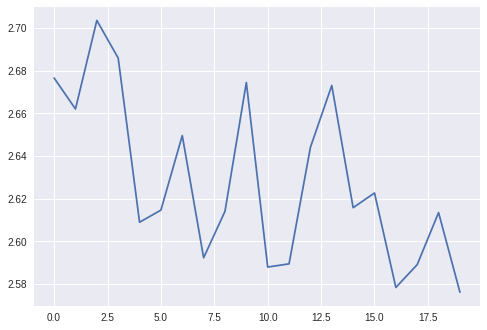

In [16]:
plt.plot(trainer.metric_history['loss'][-20:])

In [14]:
%time trainer.evaluate(val_loader)


CPU times: user 1.14 s, sys: 208 ms, total: 1.35 s
Wall time: 1.38 s


{'mAP': 0.9085555555555556}